<a href="https://colab.research.google.com/github/wilmi94/MasterThesis-AE-Codes/blob/main/MT_Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Master Thesis -1st Prototype
key aspects of this prototype:

- try to download first images using SunPy modules
- building a fist data-pipeline
  - (automatic) data/image download from JSOC
  - preprocessing of images
  - labeling
- building a simple ML model
- running a simple ConvNet
- testing the model


## Setup

In [79]:
pip install drms

In [150]:
# Standard Libaries
import os
import zipfile
import urllib
import urllib.request
import cv2
import re
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# SunPy stuff:
import drms
from astropy.io import fits
import drms

# Tensorflow stuff:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

## Getting the Data
To access the JSOC DRMS from Python, we first need to import the drms module and create an instance of the Client class:

Create DRMS client, uses the JSOC baseurl by default, set debug=True to see the DRMS query URLs

In [81]:
client = drms.Client()

All available data series can be now retrieved by calling the drms.client.Client.series() method. HMI series names start with "hmi.", AIA series names with "aia." and the names of MDI series with "mdi.".

The first (optional) parameter of this method takes a regular expression that allows you to filter the result. If you, for example, want to obtain a list of HMI series, with a name that start with the string "m_", you can write:

In [82]:
client.series(r'hmi\.m') # show available data (remove ;)

['hmi.ME_720s_fd10',
 'hmi.ME_720s_fd10_dcon',
 'hmi.ME_720s_fd10_nrt',
 'hmi.MEharp_720s',
 'hmi.MEharp_720s_nrt',
 'hmi.MHDcorona_daily_nrt',
 'hmi.M_45s',
 'hmi.M_45s_dcon',
 'hmi.M_720s',
 'hmi.M_720s_dcon',
 'hmi.M_720s_dconS',
 'hmi.Mharp_720s',
 'hmi.Mharp_720s_nrt',
 'hmi.Mrmap_latlon_720s',
 'hmi.Mrmap_latlon_720s_nrt',
 'hmi.Mrmap_lowres_latlon_720s',
 'hmi.m_720s_mod',
 'hmi.m_720s_nrt',
 'hmi.marmask_720s',
 'hmi.marmask_720s_nrt',
 'hmi.me_135s',
 'hmi.me_5760s',
 'hmi.me_720s_e15w1332',
 'hmi.me_720s_e15w1332_harp',
 'hmi.me_720s_fd10_harp',
 'hmi.me_720s_fd10_harp_nrt',
 'hmi.me_90s',
 'hmi.meanpf_720s',
 'hmi.mhdcorona',
 'hmi.mhdcorona_daily',
 'hmi.mldailysynframe_720s',
 'hmi.mldailysynframe_720s_nrt',
 'hmi.mldailysynframe_small_720s',
 'hmi.mldailysynframe_small_720s_nrt',
 'hmi.mlsynop_small_720s',
 'hmi.mrdailysynframe_720s',
 'hmi.mrdailysynframe_720s_nrt',
 'hmi.mrdailysynframe_polfil_720s',
 'hmi.mrdailysynframe_small_720s',
 'hmi.mrdailysynframe_small_720s_nr

### Downloading HMI data
download HMI synoptic data from JSOC and make a plot.

Construct the DRMS query string: “Series[Carrington rotation]”

In [95]:
qstr = 'hmi.synoptic_mr_720s[2253]' # choose series
#qstr = 'hmi.Mharp_720s_nrt[280829]'
si = client.info(qstr)  
si.segments

,type,units,protocol,dims,note
name,,,,,
synopMr,float,synoptic map,fits,VARxVAR,0.0
epts,float,effective points,fits,VARxVAR,0.0


In [96]:
#segname = 'magnetogram'
segname = 'synopMr'

In [97]:
# Send request to the DRMS server
print('Querying keyword data...\n -> {qstr}')

results, filenames = client.query(qstr, key=drms.const.all, seg=segname)
print(f' -> {len(results)} lines retrieved.')

# Use only the first line of the query result
results = results.iloc[0]
fname = f'http://jsoc.stanford.edu{filenames[segname][0]}'

# Read the data segment
# Note: HTTP downloads get cached in ~/.astropy/cache/downloads
print(f'Reading data from {fname}...')
a = fits.getdata(fname)
ny, nx = a.shape

Querying keyword data...
 -> {qstr}
 -> 1 lines retrieved.
Reading data from http://jsoc.stanford.edu/SUM19/D1487827063/S00000/synopMr.fits...


### Plot image

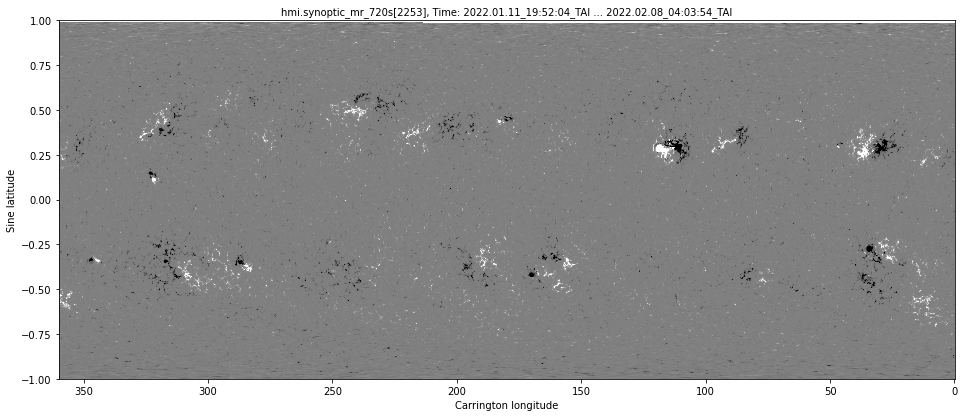

In [98]:
# Convert pixel to world coordinates using WCS keywords
xmin = (1 - results.CRPIX1) * results.CDELT1 + results.CRVAL1
xmax = (nx - results.CRPIX1) * results.CDELT1 + results.CRVAL1
ymin = (1 - results.CRPIX2) * results.CDELT2 + results.CRVAL2
ymax = (ny - results.CRPIX2) * results.CDELT2 + results.CRVAL2

# Convert to Carrington longitude
xmin = results.LON_LAST - xmin
xmax = results.LON_LAST - xmax

# Compute the plot extent used with imshow
extent = (
    xmin - abs(results.CDELT1) / 2,
    xmax + abs(results.CDELT1) / 2,
    ymin - abs(results.CDELT2) / 2,
    ymax + abs(results.CDELT2) / 2,
)

# Aspect ratio for imshow in respect to the extent computed above
aspect = abs((xmax - xmin) / nx * ny / (ymax - ymin))

# Create plot
fig, ax = plt.subplots(1, 1, figsize=(13.5, 6))
ax.set_title(f'{qstr}, Time: {results.T_START} ... {results.T_STOP}', fontsize='medium')
ax.imshow(
    a, vmin=-300, vmax=300, origin='lower', interpolation='nearest', cmap='gray', extent=extent, aspect=aspect,
)
ax.invert_xaxis()
ax.set_xlabel('Carrington longitude')
ax.set_ylabel('Sine latitude')
fig.tight_layout()

plt.show()
# f = 'synoptic_mr_720s-2150' + '.png'
# print(f)
# plt.savefig(f, bbox_inches='tight')

## Labels


### FIDO - Getting event data
Fido is a unified interface for searching and fetching solar physics data irrespective of the underlying client or webservice through which the data is obtained, e.g. VSO,JSOC_, etc. It therefore supplies a single, easy and consistent way to obtain most forms of solar physics data.

In [106]:
pip install 'sunpy'

In [108]:
# import sunpy
# sunpy.self_test()




Starting sunpy self test...
Checking for packages needed to run sunpy:
The following packages are not installed for the sunpy[jpeg2000] requirement:
  * glymur
The following packages are not installed for the sunpy[map] requirement:
  * mpl-animators
  * reproject
The following packages are not installed for the sunpy[net] requirement:
  * beautifulsoup4
  * zeep
  * drms
The following packages are not installed for the sunpy[timeseries] requirement:
  * h5netcdf
  * cdflib
The following packages are not installed for the sunpy[visualization] requirement:
  * mpl-animators
You do not have all the required dependencies installed to run the sunpy test suite.
['pytest-mock', 'pytest-doctestplus', 'pytest-mpl', 'hypothesis', 'pytest-astropy', 'jplephem']
If are using conda, you will want to run `conda install <package name>`
Otherwise you will want run `pip install "sunpy[all,tests]"`


In [134]:
from sunpy.net import Fido, attrs as a
from sunpy.net import hek2vso

In [110]:
a.Instrument.goes # define satellite/instrument

<sunpy.net.attrs.Instrument(GOES: The Geostationary Operational Environmental Satellite Program.)
object at 0x7f551d442090>

Download data from he **Heliophysics Event Knowledgebase** (HEK) which is a repository of feature and event information about the Sun.

In [128]:
tstart = '2021/12/01 00:00:56'
tend = '2022/02/09 12:40:29'
event_type = 'CE' # searches for events, see https://www.lmsal.com/hek/VOEvent_Spec.html
result = Fido.search(a.Time(tstart,tend), a.hek.EventType(event_type))
len(result[0])

383

In [132]:
#result['hek'] # inspect results...gets very huge

The ‘hek2vso’ module allows you to take an HEK event and acquire Virtual Solar Observatory (VSO) (https://sdac.virtualsolar.org/cgi/search) records specific to that event and was developed with support from the 2013 Google Summer of Code.

In [135]:
h2v = hek2vso.H2VClient()  

In [142]:
vso_records = h2v.translate_and_query(result[0])  
len(vso_records[0]) 

100%|██████████| 383/383 [05:46<00:00,  1.11records/s]


0

### DONKI
alternatively the Space Weather Database Of Notifications, Knowledge, Information (DONKI) can be used for downloading and subsequent labeling of the training and test data.

**startDate**: default to 30 days prior to current UTC date

**endDate**: default to current UTC date

**return JSON object**:

activityID, startTime, sourceLocation, activeRegionNum, instruments, cmeAnalyses, linkedEvents[(list of) activityID], note, catalog


See https://ccmc.gsfc.nasa.gov/support/DONKI-webservices.php for examples.

In [159]:
url_DONKI = 'https://kauai.ccmc.gsfc.nasa.gov/DONKI/WS/get/CME?startDate=2017-01-03&endDate=2017-01-03'
DONKI_file = urllib.request.urlopen(url_DONKI)
myfile = DONKI_file.read()

print(myfile)

b'[{"activityID":"2017-01-03T03:12:00-CME-001","catalog":"M2M_CATALOG","startTime":"2017-01-03T03:12Z","sourceLocation":"","activeRegionNum":null,"link":"https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/CME/12056/-1","note":"The CME has two stages, the first starting at 03:12Z and the second at 06:00Z. The second stage merges with the first stage and that is what is measured. The source is a small off limb eruption in the SE of SDO AIA 171 between 01:55Z and 02:43Z.","instruments":[{"displayName":"SOHO: LASCO/C2"},{"displayName":"SOHO: LASCO/C3"}],"cmeAnalyses":[{"time21_5":"2017-01-03T13:08Z","latitude":-10.0,"longitude":-105.0,"halfAngle":20.0,"speed":645.0,"type":"C","isMostAccurate":true,"note":"Measured using SOHO LASCO C3 imagery.","levelOfData":0,"link":"https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/CMEAnalysis/12059/-1","enlilList":[{"modelCompletionTime":"2017-01-03T21:57Z","au":2.0,"estimatedShockArrivalTime":null,"estimatedDuration":null,"rmin_re":null,"kp_18":null,"kp_90":null,"kp

## Data Pipeline

### Download data over a longer time interval
Now that is was shown that it is possible to download at least one HMI image and conduct a simple preprocessing

In [143]:
# Create folders
# ...tbd
# iterate over time period or Carrington rotation

#qstr = 'hmi.mrdailysynframe_720s_nrt[???????]'



# A simple ConvNet Model
First, the images have to be imported into the Python session. The first step is to process the images into a format that 
1. makes the data readable to the model, and 
2. provides more training material for the model to learn. 

For example, the train_processor variable scales the data so that it can be a feature (input) for the model, but also takes each images and **augments** it so that the model can learn from **multiple variations of the same picture**. 

It flips it horizontally, rotates it, and shifts it, and more to make sure the model learns from the shape of the bit rather than the orientation or size.

In [75]:
# Data processing
train_processor = ImageDataGenerator(rescale = 1./255, \
    horizontal_flip = True, zoom_range = 0.2,          \
    rotation_range = 10, shear_range = 0.2,            \
    height_shift_range = 0.1, width_shift_range = 0.1)
test_processor = ImageDataGenerator(rescale = 1./255)

# Load data
train = train_processor.flow_from_directory('train',   \
    target_size = (256, 256), batch_size = 32,         \
    class_mode = 'categorical', shuffle = True)

test = test_processor.flow_from_directory('test',      \
    target_size = (256 ,256), batch_size = 32,         \
    class_mode = 'categorical', shuffle = False)

FileNotFoundError: ignored

## Model building
Next step is to build the CNN model with options for building the model. This includes the number of convolutional layers, fully connected dense layers, the number of nodes in each layer, and the number of training epochs. For more information on these parameters and Convolutional Neural Networks in general, see Computer Vision with Deep Learning. Change these parameters and analyze the performance of the model.

In [ ]:
# choose model parameters
num_conv_layers = 2
num_dense_layers = 1
layer_size = 64
num_training_epochs = 20

In [ ]:
# Initiate model variable
model = Sequential()

# begin adding properties to model variable
# e.g. add a convolutional layer
model.add(Conv2D(layer_size, (3, 3), input_shape=(256,256, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# add additional convolutional layers based on num_conv_layers
for _ in range(num_conv_layers-1):
    model.add(Conv2D(layer_size, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

# reduce dimensionality
model.add(Flatten())

# add fully connected "dense" layers if specified
for _ in range(num_dense_layers):
    model.add(Dense(layer_size))
    model.add(Activation('relu'))

# add output layer
model.add(Dense(3))
model.add(Activation('softmax'))

# compile the sequential model with all added properties
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'],
                )

# use the data already loaded previously to train/tune the model
model.fit(train,
            epochs=num_training_epochs,
            validation_data = test)

# save the trained model
model.save(f'bits.h5')

## Model Testing
The model is trained and saved as an h5 file. The last line of the printed output contains the accuracy for both the training and testing data.

The val_accuracy is the accuracy on the test images that are not included in the training. Hyperparameter optimization can be used to improve the accuracy by adjusting the CNN architecture, training selections, or other parameters. The function make_prediction takes the file path to a drill bit photo as an input and produces a classification result.

In [ ]:
btype = ['PDC', 'Roller Cone', 'Spoon'] # possible output values
def make_prediction(image_fp):
    im = cv2.imread(image_fp) # load image
    plt.imshow(im)
    img = image.load_img(image_fp, target_size = (256,256))
    img = image.img_to_array(img)

    image_array = img / 255. # scale the image
    img_batch = np.expand_dims(image_array, axis = 0)
    
    predicted_value = btype[model.predict(img_batch).argmax()]
    true_value = re.search(r'(PDC)|(Roller Cone)|(Spoon)', image_fp)[0]
    
    out = f"""Predicted Bit Type: {predicted_value}
    True Bit Type: {true_value}
    Correct?: {predicted_value == true_value}"""
    
    return out

In [ ]:
# randomly select type (1-3) and image number (1-5)
i = random.randint(0,2); j = random.randint(1,5)
b = btype[i]; im = b.replace(' ','_').lower() + '_' + str(j) + '.jpg'
test_image_filepath = r'./test/'+b+'/'+im
print(make_prediction(test_image_filepath))